In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scanpy as sc

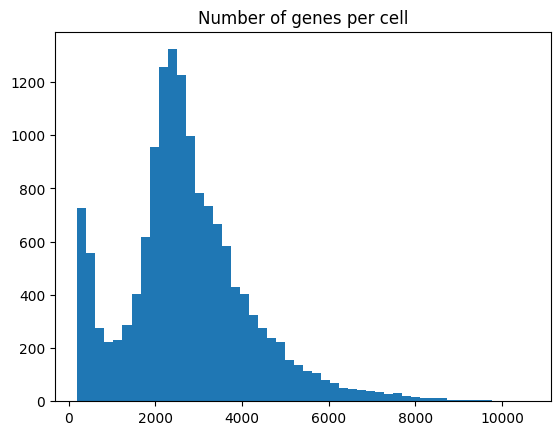

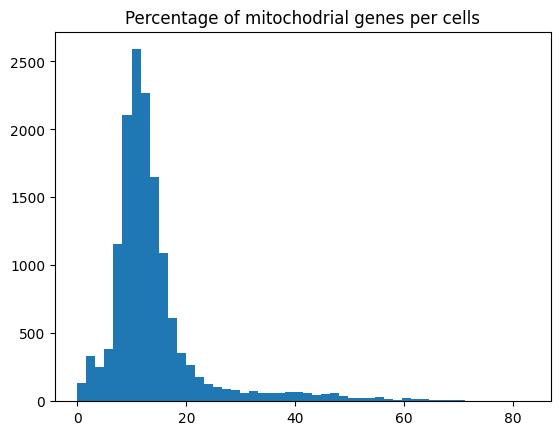

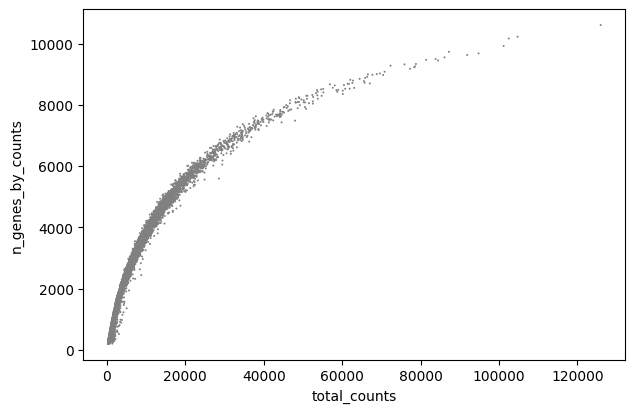

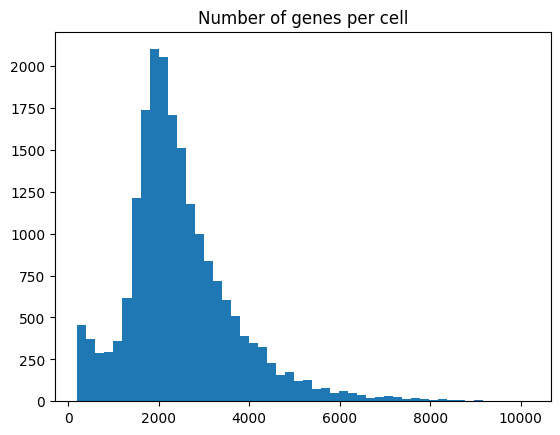

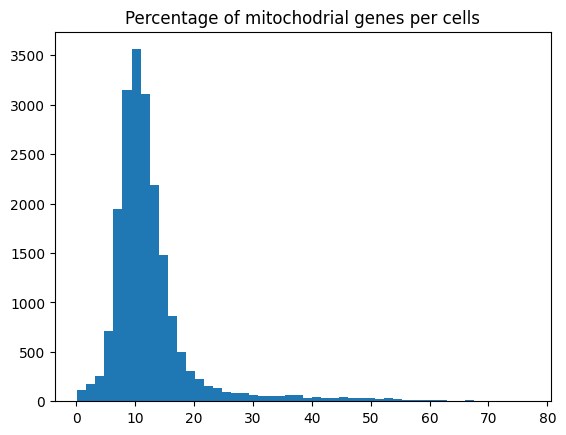

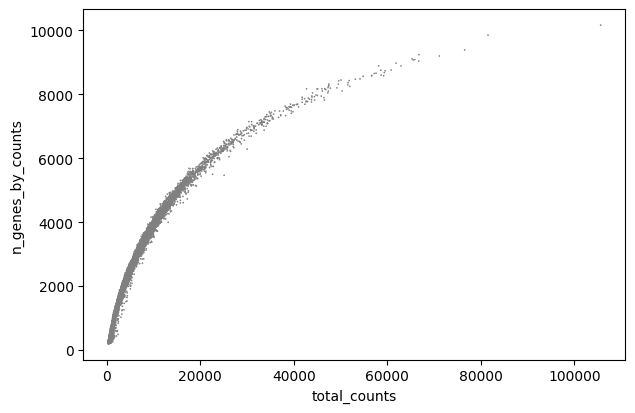

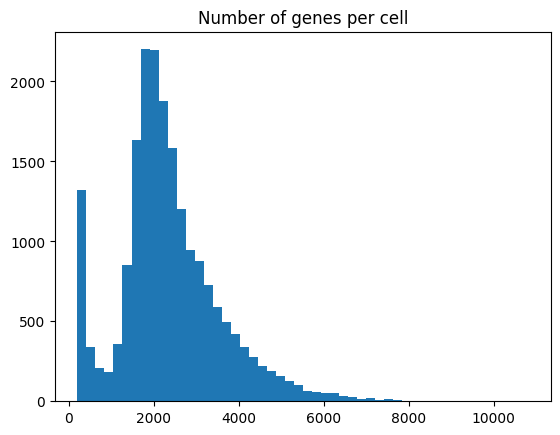

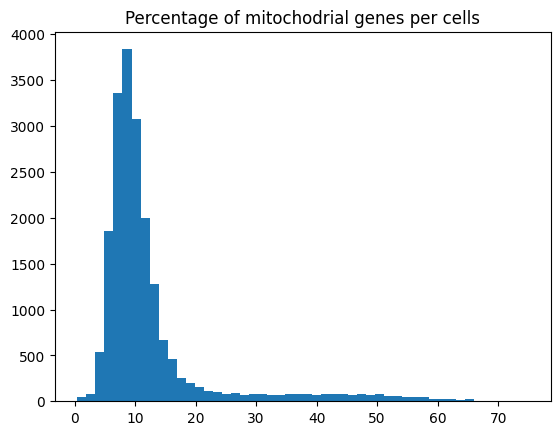

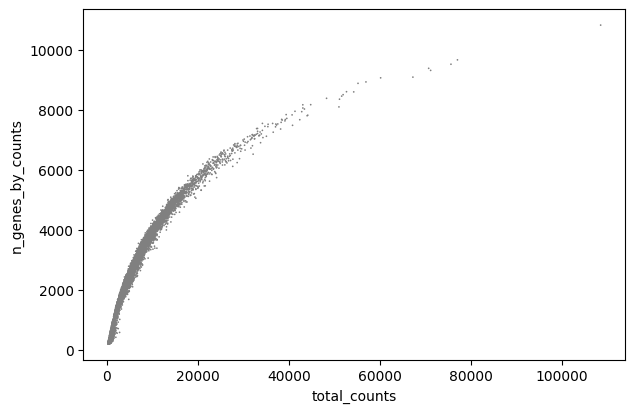

In [32]:
dir_name = ['D8_1','D8_2','D12_1','D12_2','D20_1', 'D20_2', 'D22_1', 'D22_2']

adatasets = []
for name in dir_name:

    exec(f"adata_tmp = sc.read_10x_mtx('../data/initial_10x_outputs/' + 'filtered_feature_bc_matrix-' + name)")

    #sc.pl.highest_expr_genes(adata_tmp, n_top=20)

    #Basic filtering genes not expressed + cell with too few genes
    sc.pp.filter_cells(adata_tmp, min_genes=200)
    sc.pp.filter_genes(adata_tmp, min_cells=3)

    #Define the mitochondrial genes + compute QC metrics
    adata_tmp.var["mt"] = adata_tmp.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
        adata_tmp, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    
    #Visualization QC metrics
    plt.hist(adata_tmp.obs.n_genes, bins=50)
    plt.title("Number of genes per cell")
    plt.show()

    plt.hist(adata_tmp.obs.pct_counts_mt, bins=50)
    plt.title("Percentage of mitochodrial genes per cells")
    plt.show()

    sc.pl.scatter(adata_tmp, x="total_counts", y="n_genes_by_counts")

    #Filter cells 
    #Remove all cell with % mt > 20% + extreme total counts
    adata_tmp = adata_tmp[adata_tmp.obs.pct_counts_mt < 20]
    adata_tmp = adata_tmp[adata_tmp.obs.total_counts < 100000]
    adata_tmp = adata_tmp[adata_tmp.obs.n_genes > 8000 and adata_tmp.obs.n_genes < 6000]
    
    adatasets.append(adata_tmp)        
    

adata = adatasets[0]


In [20]:
adata = adata.concatenate(adatasets[1:], join="outer")


/var/folders/nx/fx90wvl146lcdkglfty5_wr4qnvn43/T/ipykernel_63499/4267013762.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata.concatenate(adatasets[1:], join="outer")


In [24]:
adata

AnnData object with n_obs × n_vars = 106047 × 18527
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'n_counts'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'mt-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'mt-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'mt-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'mt-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'mt-5', 'n_cells_by_counts-5', 'mean_counts-5', 'pct_dropout_by_counts-5', 'total_cou

In [23]:
# Normalize + log transform
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()

#Scale each to unit variance 
sc.pp.scale(adata, max_value=10)

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


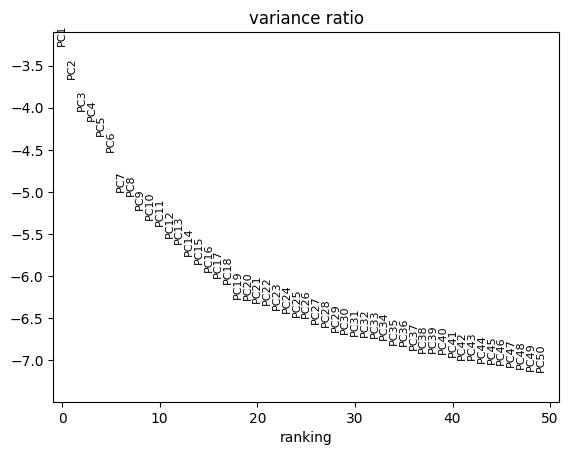

In [27]:
#Compute PCA
sc.tl.pca(adata, svd_solver="arpack")

#Variance to pick number of PCs
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

/Users/adorman/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


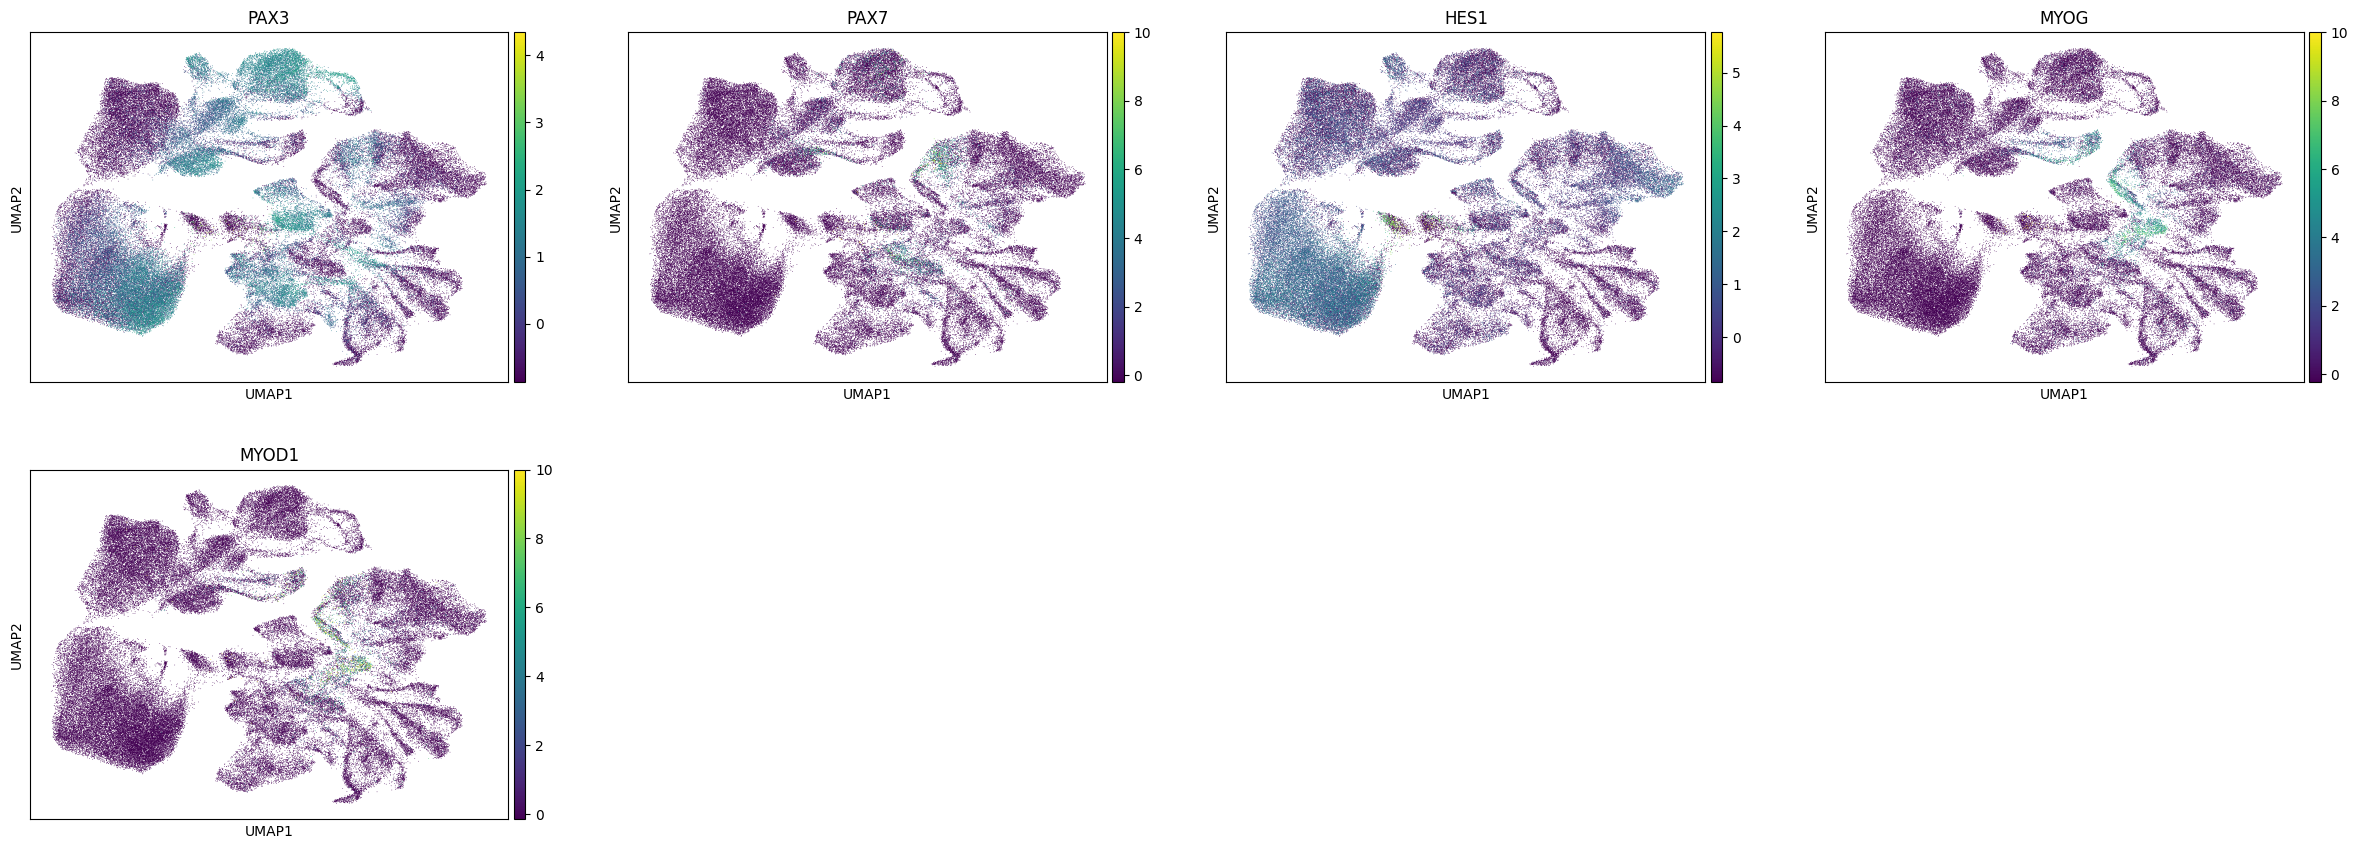

In [28]:
#Create neighbohood of cells
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

sc.tl.umap(adata)
sc.pl.umap(adata, color=["PAX3",'PAX7','HES1','MYOG','MYOD1'])

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/

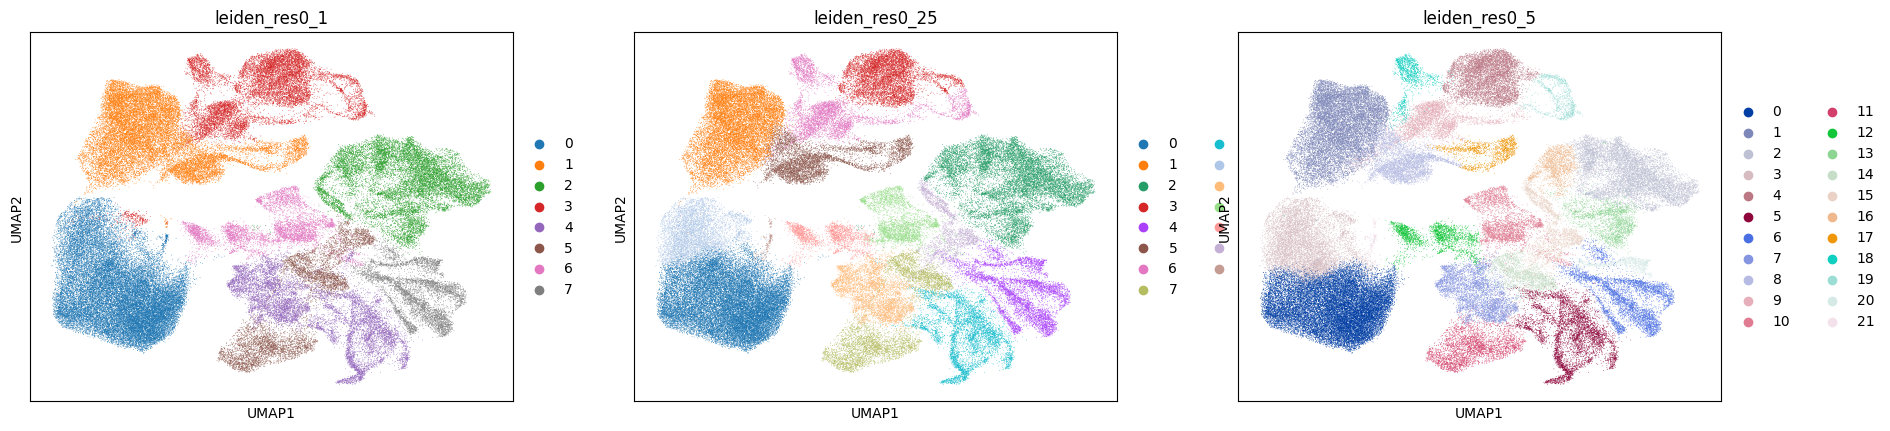

In [29]:
#Clustering
sc.tl.leiden(
    adata,
    resolution=0.1,
    random_state=0,
    key_added="leiden_res0_1"
)
sc.tl.leiden(
    adata,
    resolution=0.25,
    random_state=0,
    key_added="leiden_res0_25"
)
sc.tl.leiden(
    adata,
    resolution=0.5,
    random_state=0,
    key_added="leiden_res0_5"
)
sc.pl.umap(adata, color=["leiden_res0_1",'leiden_res0_25','leiden_res0_5'])

/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/adorman/.local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/adorman/.local/

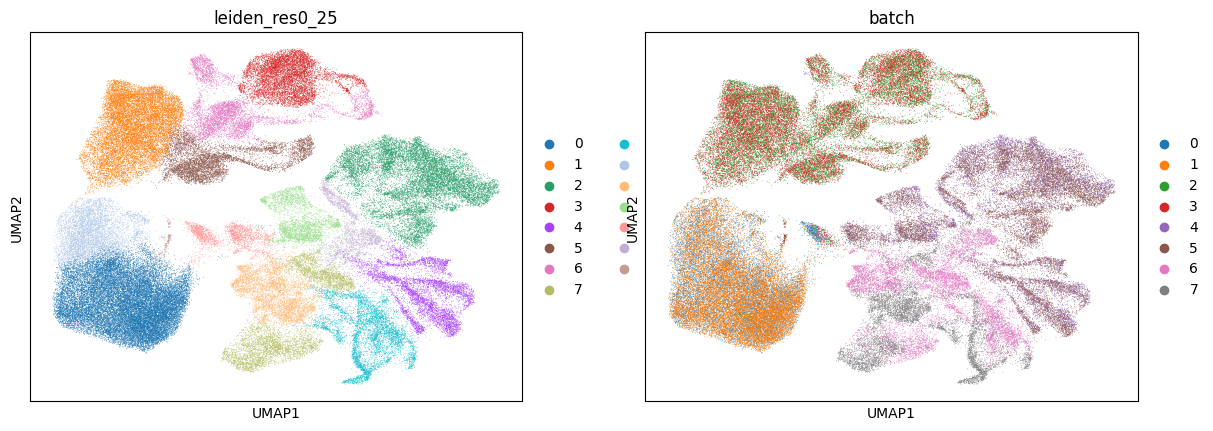

In [31]:
sc.pl.umap(adata, color=['leiden_res0_25','batch'])